In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
# Import arsitektur model tambahan
from tensorflow.keras.applications import MobileNetV2, ResNet50V2, VGG16
# Import fungsi preprocessing masing-masing model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_prep
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_prep
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_prep

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_prep
from tensorflow.keras.applications.densenet import preprocess_input as dense_prep

from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import os

# Konfigurasi
DATASET_DIR = 'Dataset_Anggur'
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001
SPLIT_RATIO = 0.2

Sel ini memuat seluruh dependensi yang diperlukan: TensorFlow/Keras untuk pemodelan, MobileNetV2 untuk transfer learning, utilitas augmentasi dan optimizer, serta paket evaluasi (`class_weight`, `classification_report`, `confusion_matrix`) dan visualisasi (`matplotlib`, `seaborn`). Dengan begitu semua fungsi berikutnya tinggal fokus ke logika eksperimen tanpa harus mengimpor ulang.

Konfigurasi global ini menentukan lokasi dataset anggur, resolusi input, ukuran batch, jumlah epoch, learning rate, dan rasio validasi. Nilai-nilai tersebut dipakai konsisten oleh generator data, kedua arsitektur model, dan proses training sehingga perubahan eksperimen cukup dilakukan di satu tempat.

## 2. Visualisasi sebelum dan sesudah pre-proccesing

Visualisasi 4 Sampel Per Kelas:


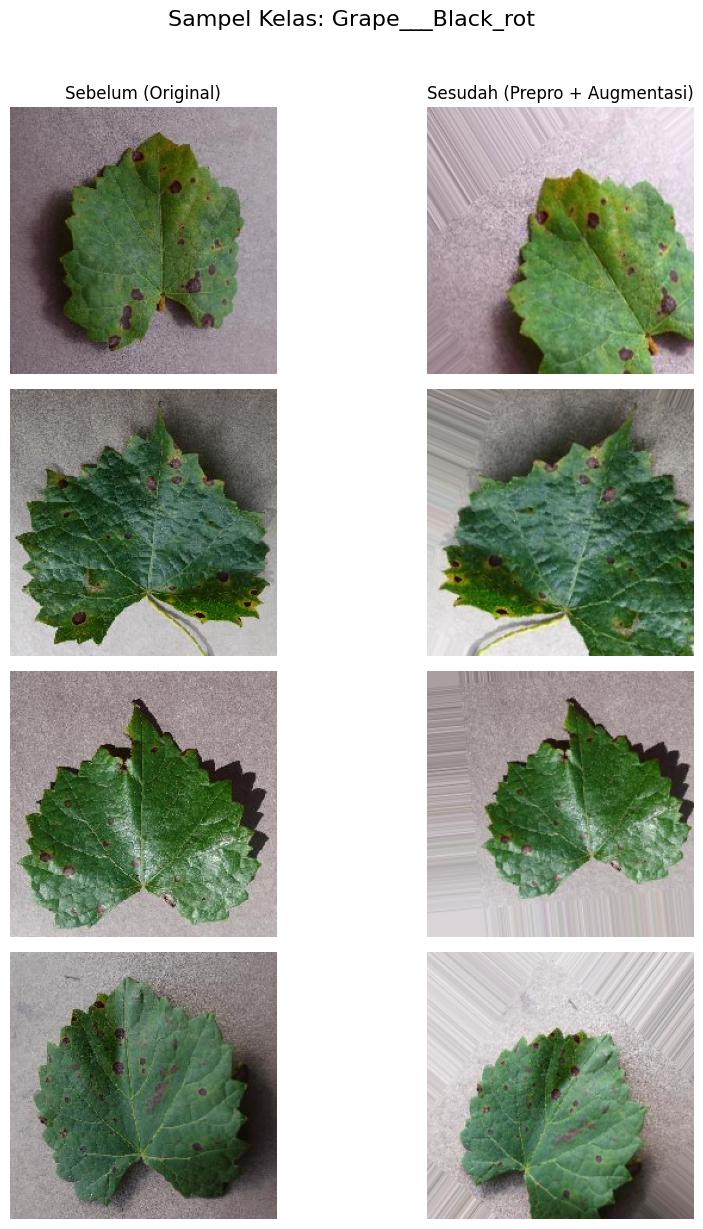

--------------------------------------------------------------------------------


KeyboardInterrupt: 

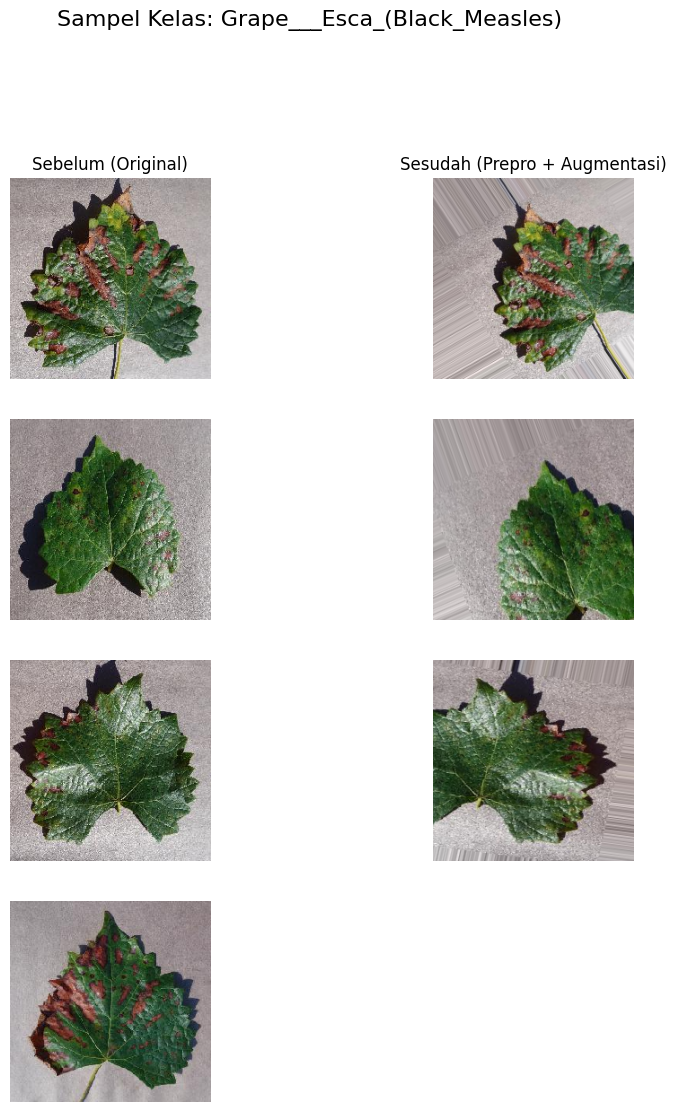

In [6]:
def visualize_preprocessing_per_class(dataset_dir, num_samples=4):
    # Dapatkan list kelas (nama folder)
    class_list = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    
    # Setup Data Generator (Sama seperti sebelumnya)
    datagen_sample = ImageDataGenerator(
        preprocessing_function=mobile_prep, # Menggunakan mobilenet prep
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Loop untuk setiap kelas
    for class_name in class_list:
        class_path = os.path.join(dataset_dir, class_name)
        # Ambil daftar file gambar, batasi hanya sejumlah num_samples (misal 4)
        images = os.listdir(class_path)[:num_samples]
        
        # Buat Frame Plotting: Tinggi disesuaikan dengan jumlah sampel
        plt.figure(figsize=(10, 3 * num_samples)) 
        plt.suptitle(f"Sampel Kelas: {class_name}", fontsize=16, y=1.02)
        
        for i, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            
            try:
                # 1. Load Gambar Asli
                original_img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                img_array = img_to_array(original_img)
                
                # 2. Preprocessing
                img_batch = np.expand_dims(img_array, axis=0)
                aug_iter = datagen_sample.flow(img_batch, batch_size=1)
                aug_img = next(aug_iter)[0]
                
                # Normalisasi untuk visualisasi (karena prepro bikin nilai jadi aneh/negatif)
                display_aug = (aug_img - aug_img.min()) / (aug_img.max() - aug_img.min())

                # Plot Gambar Asli (Kolom Kiri)
                plt.subplot(num_samples, 2, 2*i + 1)
                if i == 0: plt.title("Sebelum (Original)")
                plt.imshow(img_array.astype('uint8'))
                plt.axis('off')
                
                # Plot Gambar Hasil Prepro (Kolom Kanan)
                plt.subplot(num_samples, 2, 2*i + 2)
                if i == 0: plt.title("Sesudah (Prepro + Augmentasi)")
                plt.imshow(display_aug)
                plt.axis('off')
                
            except Exception as e:
                print(f"Error memproses gambar {img_name}: {e}")
                continue

        plt.tight_layout()
        plt.show()
        print("-" * 80) # Separator antar kelas

# Jalankan Fungsi
print("Visualisasi 4 Sampel Per Kelas:")
try:
    visualize_preprocessing_per_class(DATASET_DIR, num_samples=4)
except Exception as e:
    print(f"Gagal: {e}")

## 3. Definisi 4 Model 

In [ ]:
# 1. Custom CNN (Baseline)
def build_custom_cnn(num_classes):
    model = Sequential(name='Custom_CNN')
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# 2. MobileNetV2 (Transfer Learning - Ringan)
def build_mobilenet(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True # Fine Tuning
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions, name='MobileNetV2')

# 3. [BARU] ResNet50V2 (Residual Network - Menengah/Berat)
def build_resnet50(num_classes):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True 
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions, name='ResNet50V2')

# 4. [BARU] VGG16 (Deep CNN Klasik - Berat)
def build_vgg16(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions, name='VGG16')

# 5. EfficientNetB0 (Sangat Direkomendasikan)
def build_efficientnet(num_classes):
    # EfficientNet biasanya butuh input shape (224, 224, 3)
    # Weights='imagenet' agar transfer learning jalan
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # EfficientNetB0 bisa di-unfreeze beberapa layer atasnya agar adaptasi lebih baik
    # Tapi untuk awal, kita freeze dulu atau trainable=True semua juga oke jika LR kecill
    base_model.trainable = True 
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x) # Tambahan Batchnorm sering membantu di EfficientNet
    x = Dropout(0.2)(x)         # Dropout agar tidak overfitting
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=predictions, name='EfficientNetB0')

# 6. DenseNet121 (Alternatif Kuat)
def build_densenet(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=predictions, name='DenseNet121')

## 4. Training Loop & Evaluasi Komparatif

In [ ]:
# --- 1. Konfigurasi Model ---
models_config = [
    ('DenseNet121', build_densenet, dense_prep),
    ('EfficientNetB0', build_efficientnet, eff_prep),
    ('Custom CNN', build_custom_cnn, None),
    ('MobileNetV2', build_mobilenet, mobile_prep),
    ('ResNet50V2', build_resnet50, resnet_prep),
    ('VGG16', build_vgg16, vgg_prep)
]

history_storage = {}
final_accuracies = {}

# --- 2. Hitung Bobot Kelas (Class Weights) --
print("Menghitung bobot kelas dan memuat data...")
# Gunakan generator sementara untuk scanning data
dummy_gen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT_RATIO)
temp_gen = dummy_gen.flow_from_directory(DATASET_DIR, subset='training')

NUM_CLASSES = temp_gen.num_classes
class_names = list(temp_gen.class_indices.keys())
cls_train = temp_gen.classes

# Hitung bobot agar training adil (balanced)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(cls_train), 
    y=cls_train
)
weights_dict = dict(enumerate(class_weights))

print(f"Kelas Terdeteksi: {class_names}")
print(f"Bobot Kelas: {weights_dict}")

# --- 3. Loop Training Semua Model ---
for name, builder, preproc_func in models_config:
    print(f"\n{'='*50}")
    print(f"MULAI TRAINING: {name}")
    print(f"{'='*50}")
    
    # A. Siapkan Generator Khusus
    if preproc_func is None:
        # Untuk Custom CNN (perlu rescale manual)
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30, 
            width_shift_range=0.2, 
            height_shift_range=0.2,
            shear_range=0.2, 
            zoom_range=0.2, 
            horizontal_flip=True,
            validation_split=SPLIT_RATIO
        )
    else:
        # Untuk Transfer Learning (gunakan fungsi preprocess bawaan)
        train_datagen = ImageDataGenerator(
            preprocessing_function=preproc_func,
            rotation_range=30, 
            width_shift_range=0.2, 
            height_shift_range=0.2,
            shear_range=0.2, 
            zoom_range=0.2, 
            horizontal_flip=True,
            validation_split=SPLIT_RATIO
        )

    # B. Buat Flow Data
    train_generator = train_datagen.flow_from_directory(
        DATASET_DIR, 
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE, 
        class_mode='categorical', 
        subset='training', 
        shuffle=True
    )
    
    test_generator = train_datagen.flow_from_directory(
        DATASET_DIR, 
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE, 
        class_mode='categorical', 
        subset='validation', 
        shuffle=False
    )

    # C. Build & Compile Model
    tf.keras.backend.clear_session() # Hapus sesi lama agar RAM lega
    model = builder(NUM_CLASSES)
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # D. Proses Training
    # Menggunakan len(generator) agar tidak muncul warning 'ran out of data'
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator), 
        validation_data=test_generator,
        validation_steps=len(test_generator),
        epochs=EPOCHS,
        class_weight=weights_dict,
        verbose=1
    )
    
    # E. Simpan History
    history_storage[name] = history.history
    
    # F. Evaluasi Akhir
    print(f"\nEvaluasi Akhir {name}:")
    loss, acc = model.evaluate(test_generator, verbose=0)
    final_accuracies[name] = acc * 100
    print(f"--> Akurasi Validasi: {acc*100:.2f}%")

Menghitung bobot kelas dan memuat data...
Found 3251 images belonging to 4 classes.
Kelas Terdeteksi: ['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']
Bobot Kelas: {0: np.float64(0.8609639830508474), 1: np.float64(0.7341915085817525), 2: np.float64(0.9439605110336817), 3: np.float64(2.3974926253687316)}

MULAI TRAINING: DenseNet121
Found 3251 images belonging to 4 classes.
Found 811 images belonging to 4 classes.

Epoch 1/10
 16/102 ━━━━━━━━━━━━━━━━━━━━ 10:06 7s/step - accuracy: 0.3982 - loss: 1.2632

KeyboardInterrupt: 

## 5. Komparasi Hasil (Grafik)

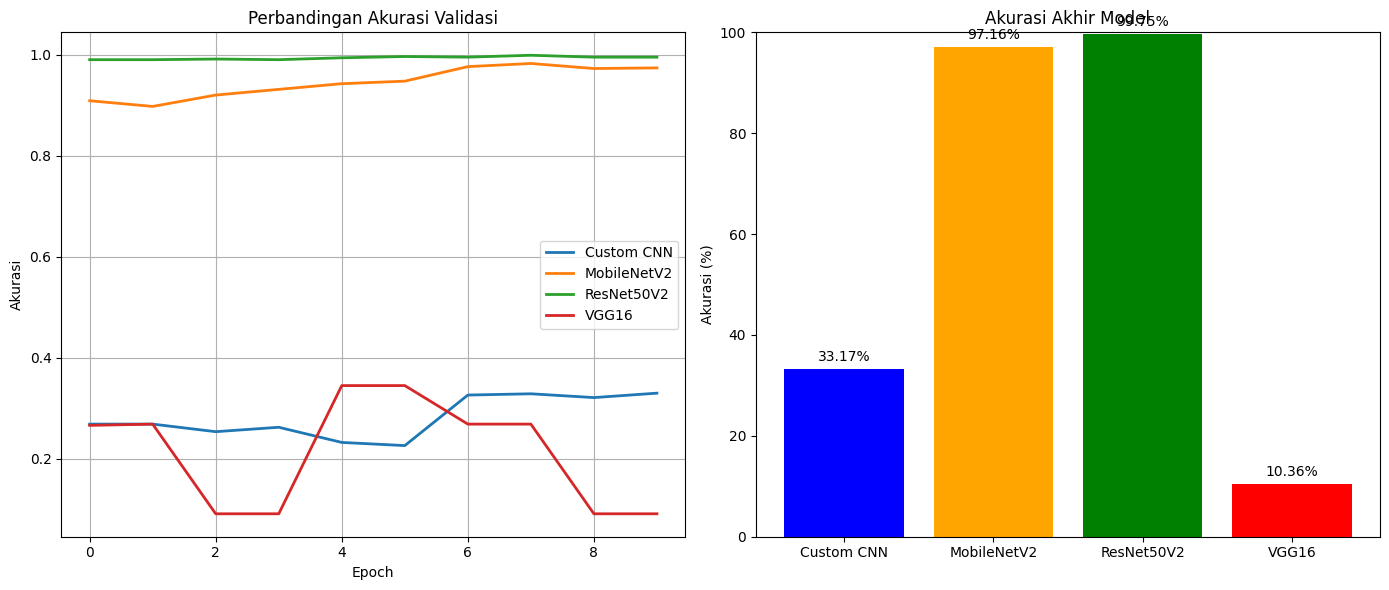

In [ ]:
import matplotlib.cm as cm
import numpy as np

# Pastikan history_storage dan final_accuracies sudah terisi dari proses training sebelumnya

# Setup Ukuran Plot
plt.figure(figsize=(15, 6))

# --- Subplot 1: Kurva Akurasi Validasi ---
plt.subplot(1, 2, 1)
for name, hist in history_storage.items():
    # Mengambil val_accuracy (pastikan key-nya sesuai versi keras, biasanya 'val_accuracy')
    acc_data = hist.get('val_accuracy') or hist.get('val_acc') 
    if acc_data:
        plt.plot(acc_data, label=name, linewidth=2)

plt.title('Dinamika Akurasi Validasi per Epoch')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

# --- Subplot 2: Bar Chart Akurasi Akhir ---
plt.subplot(1, 2, 2)
names = list(final_accuracies.keys())
values = list(final_accuracies.values())

# PERBAIKAN 1: Membuat warna dinamis sesuai jumlah model (agar tidak error)
colors = cm.turbo(np.linspace(0, 1, len(names))) 

bars = plt.bar(names, values, color=colors)

plt.title('Perbandingan Akurasi Akhir')
plt.ylabel('Akurasi (%)')
plt.ylim(0, 100) # Batas y dari 0 sampai 100

# PERBAIKAN 2: Memiringkan nama model agar tidak bertumpuk
plt.xticks(rotation=45, ha='right')

# Tambahkan label angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 1, 
        f"{yval:.2f}%", 
        ha='center', 
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()